# Example: direct lunar transfer

Here is an example computing a transfer from LEO to a L2 Halo orbit.

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp

In [2]:
import sys
import os
sys.path.append('../../../')
import stardust

In [3]:
# constants of CR3BP dynamics
mu = 1.215058560962404e-02
mu1 = 1 - mu
mu2 = mu

# canonical scalars
LU = 389703     # km
TU = 382981     # sec

In [4]:
# initial state
rv0 = np.array([
    -mu + 6578/LU,
    0.0,
    0.0,
    0.0,
    np.sqrt((1-mu)/mu),
    0.0
])
period_0 = 1*86400/TU
sol0_ballistic = solve_ivp(stardust.eom_rotating_cr3bp, (0, period_0), rv0, args=(mu, mu1, mu2), 
                            method='RK45', rtol=1e-12, atol=1e-12)

rvf = np.array([1.018826173554963,
                0,
                 -0.179797844569828,
                0,
                -0.09618908984512,
                0])
period_f = 2.3538670417546639E+00
solf_ballistic = solve_ivp(stardust.eom_rotating_cr3bp, (0, period_f), rvf, args=(mu, mu1, mu2),
                            method='RK45', rtol=1e-12, atol=1e-12)

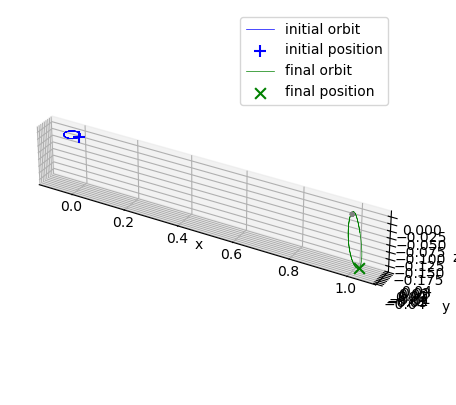

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol0_ballistic.y[0, :], sol0_ballistic.y[1, :], sol0_ballistic.y[2, :], 
        color='blue', label='initial orbit', lw=0.5)
ax.scatter(sol0_ballistic.y[0,0], sol0_ballistic.y[1,0], sol0_ballistic.y[2,0], 
           color='blue', label='initial position', marker="+", s=80)

ax.plot(solf_ballistic.y[0, :], solf_ballistic.y[1, :], solf_ballistic.y[2, :],
        color='green', label='final orbit', lw=0.5)
ax.scatter(solf_ballistic.y[0,0], solf_ballistic.y[1,0], solf_ballistic.y[2,0], 
           color='green', label='final position', marker="x", s=60)

ax.legend()
stardust.plot_sphere_wireframe(ax, 1737/384400, [1-mu,0,0], color='grey')
ax.set(xlabel="x", ylabel="y", zlabel="z")
ax.set_aspect('equal', 'box')
plt.show()

In [6]:
# construct problem
args = (mu, mu1, mu2)
# tspan = [0, 57.4*86400/TU]
tspan = [0, 3.5*86400/TU]
N = 100
prob = stardust.FixedTimeTwoStageLeastSquares(
    stardust.eom_stm_rotating_cr3bp,
    rv0,
    rvf,
    tspan,
    N = N,
    args = args,
)

In [7]:
print(f"Solving outer loop...")
weights = [0.9,0.9,0.9] + [1,1,1] * (N-1)
tstart = time.time()
exitflag, iter_sols = prob.solve(
    maxiter = 10, 
    maxiter_inner = 30,
    save_all_iter_sols = True,
    verbose_inner = True,
    weights = weights)
tend = time.time()
print(f"Elapsed time = {tend - tstart} sec")
print(f"exitflag = {exitflag}")

Solving outer loop...
    Inner loop 0: max position residual norm: 7.8420e-03
    Inner loop 1: max position residual norm: 3.5899e-06
    Inner loop 2: max position residual norm: 2.0260e-10
    Inner loop converged to within tolerance 1e-08 in 2 iterations!
  Computing outer-loop sparse Jacobian...


  Computing outer-loop Jacobian:   0%|          | 0/98 [00:00<?, ?it/s]

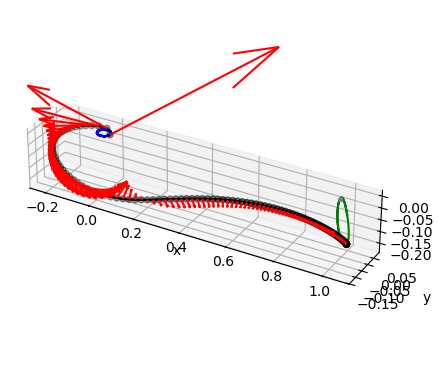

In [23]:
# plot trajectory
fig, ax, sols_check = prob.plot_trajectory(use_itm_nodes=False, show_maneuvers=False)

# in-between guesses
# for _sols in iter_sols:
#     for _sol in _sols:
#         ax.plot(_sol.y[0,:], _sol.y[1,:], _sol.y[2,:], color='black', lw=0.5)
ax.quiver(prob.nodes[:,0], prob.nodes[:,1], prob.nodes[:,2], 
        prob.v_residuals[:,0], prob.v_residuals[:,1], prob.v_residuals[:,2],
        color='red')
ax.plot(sol0_ballistic.y[0,:], sol0_ballistic.y[1,:], sol0_ballistic.y[2,:], color='blue')
ax.plot(solf_ballistic.y[0,:], solf_ballistic.y[1,:], solf_ballistic.y[2,:], color='green')
stardust.plot_sphere_wireframe(ax, 1737/384400, [1-mu,0,0], color='grey')
ax.set(xlabel="x", ylabel="y", zlabel="z")
ax.set_aspect('equal', 'box')
plt.show()

In [24]:
sols_transfer = prob.propagate()
np.sum( (prob.v_residuals * prob.v_residuals).sum(axis=1)**0.5 )

np.float64(9.146389349288288)

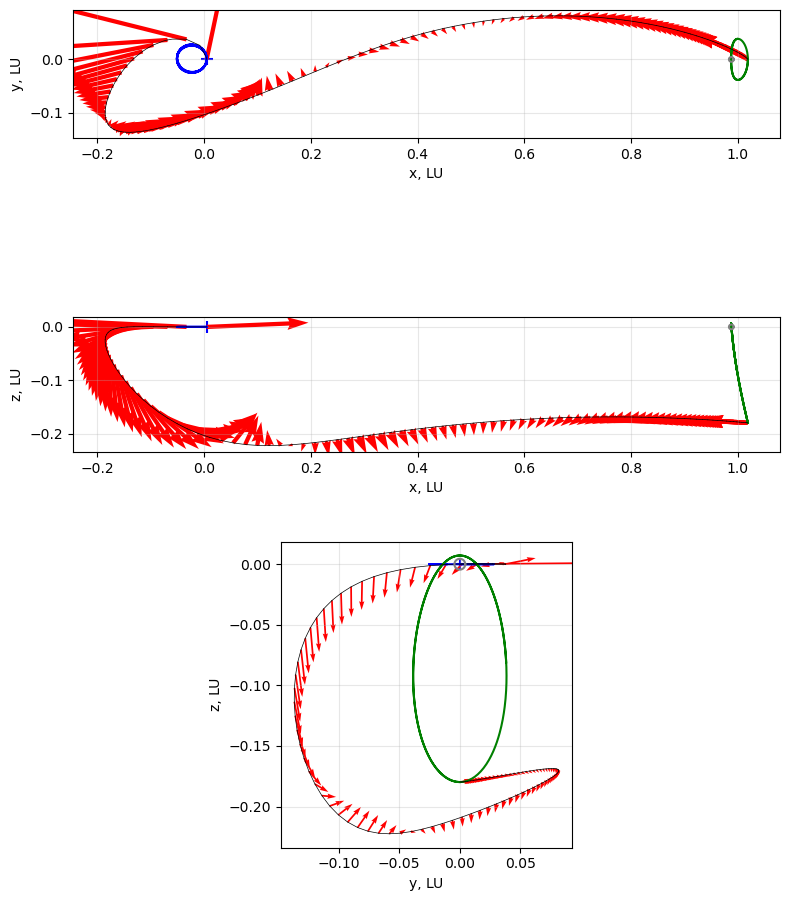

In [25]:
fig, axs = plt.subplots(3,1,figsize=(8,10))

ixys = [[0,1], [0,2], [1,2]]
labels = [['x, LU', 'y, LU'], ['x, LU', 'z, LU'], ['y, LU', 'z, LU']]
moon_coords = [[1-mu,0], [1-mu,0], [0,0]]
for ixy,ax,label, moon_coord in zip(ixys, axs, labels, moon_coords):
    ax.plot(sol0_ballistic.y[ixy[0],:], sol0_ballistic.y[ixy[1],:], color='blue', label='initial orbit')
    ax.plot(solf_ballistic.y[ixy[0],:], solf_ballistic.y[ixy[1],:], color='green', label='final orbit')
    for sol in sols_transfer:
        ax.plot(sol.y[ixy[0],:], sol.y[ixy[1],:], color='black', lw=0.5)
    ax.scatter(rv0[ixy[0]], rv0[ixy[1]], color='blue', marker="+", s=80)
    ax.quiver(prob.nodes[:,ixy[0]], prob.nodes[:,ixy[1]], 
            prob.v_residuals[:,ixy[0]], prob.v_residuals[:,ixy[1]],
            color='red')
    stardust.plot_circle(ax, 1737/LU, moon_coord, color='grey')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set(xlabel=label[0], ylabel=label[1])
plt.tight_layout()
plt.show()